# Packages

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import numpy as np
import torchfile
from PIL import Image
import cv2
import time
import random
import os

In [27]:
# 定义RGB通道的中值
_BGR_MEANS = np.array([103.94, 116.78, 123.68])

# Other Functions

In [28]:
def Scale_image_uint8(image):
    '''
    将一个numpy矩阵缩放至[0, 255]范围内并将其转化为uint8类型
    '''
    float_image = image.astype(np.float32)   #先将图片矩阵转化为浮点类型
    imax = float_image.max()                 #取其中的最大值最小值
    imin = float_image.min()
    diff = abs(imax - imin)                  # 最大最小值做差取绝对值
    normalized_image = (float_image - imin) / diff   #归一化处理
    return (normalized_image * 255).astype(np.uint8)   #返回处理过的图片矩阵

In [29]:
def Clip_image_uint8(image):
    '''
    将一个numpy矩阵限制到[0, 255]范围内，不满足条件的剪切掉并将其转化为uint8类型
    '''
    image = np.clip(image, 0, 255)   #将图片的数组切割到[0, 255]范围内
    return image.astype(np.uint8)

In [30]:
def graph_from_t7(net, graph, t7_file):
    '''
    从保存的模型中加载需要使用的网络
    :第一个参数是torch神经网络
    :第二个参数是绘制的Tensorflow图像
    :第三个参数是使用的模型文件
    '''
    layers = []
    print_layers = []#[0, 30]
    t7 = torchfile.load(t7_file,force_8bytes_long=True)
    
    with graph.as_default():

        for idx, module in enumerate(t7.modules):
        
            if idx in print_layers:
                print(module)
            
            if module._typename == b'nn.SpatialReflectionPadding':
                left = module.pad_l
                right = module.pad_r
                top = module.pad_t
                bottom = module.pad_b
                net = tf.pad(net, [[0,0], [top, bottom], [left, right], [0,0]], 'REFLECT')
                layers.append(net)
            elif module._typename == b'nn.SpatialConvolution':
                weight = module.weight.transpose([2,3,1,0])
                bias = module.bias
                strides = [1, module.dH, module.dW, 1]  
                net = tf.nn.conv2d(net, weight, strides, padding='VALID')
                net = tf.nn.bias_add(net, bias)
                layers.append(net)
            elif module._typename == b'nn.ReLU':
                net = tf.nn.relu(net)
                layers.append(net)
            elif module._typename == b'nn.SpatialUpSamplingNearest':
                d = tf.shape(net)
                size = [d[1] * module.scale_factor, d[2] * module.scale_factor]
                net = tf.compat.v1.image.resize_nearest_neighbor(net, size)
                layers.append(net)
            elif module._typename == b'nn.SpatialMaxPooling':
                net = tf.nn.max_pool(net, ksize=[1, module.kH, module.kW, 1], strides=[1, module.dH, module.dW, 1],
                                   padding='VALID', name = str(module.name, 'utf-8'))
                layers.append(net)
            else:
                raise NotImplementedError(module._typename)
        
        return net, layers

In [31]:
def Offset_image(image, means):
    image = tf.to_float(image)
    channels = tf.split(axis=3, num_or_size_splits=3, value=image)
    for i in range(3):
        channels[i] += means[i]
    image = tf.concat(axis=3, values=channels)
    return image

In [32]:
def preprocess_image(image, size=None):
    
    # 预训练的模型中图片以BGR顺序排序，因此需要进行通道的重排，并将其作为网络输入；正常输出的图片通道顺序为RGB
    image = tf.reverse(image, axis=[-1])
    #image = _offset_image(image, -1*_BGR_MEANS)
    image = tf.cast(image, tf.float32) / 256.0
    if size is not None:
        image = tf.image.resize(image, size)
    return image

In [33]:
def postprocess_image(image, size=None):
    #image = _offset_image(image, _BGR_MEANS)
    image = image * 256
    
    # 翻转回RGB图像
    image = tf.reverse(image, axis=[-1])
    return image

In [34]:
def image_from_file(graph, placeholder_name, size=None):
    with graph.as_default():
        filename = tf.compat.v1.placeholder(tf.string, name=placeholder_name)
        image = tf.image.decode_jpeg(tf.compat.v1.read_file(filename))
        image = tf.expand_dims(image, 0)
        image = preprocess_image(image, size)
        return image, filename

In [35]:
def AdaIN(content_features, style_features, alpha):
    '''
    规范层定义：
    利用风格特征中的缩放和偏置来对内容特征进行归一化，让内容图像与风格图像的特征输入保持均衡
    '''
    style_mean, style_variance = tf.nn.moments(style_features, [1,2], keepdims=True)
    content_mean, content_variance = tf.nn.moments(content_features, [1,2], keepdims=True)
    epsilon = 1e-5
    normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), epsilon)
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features
    return normalized_content_features

In [11]:
def stylize(content, style, alpha, vgg_t7_file, decode_t7_file, resize=[512,512]):
    '''
    :第一个参数是内容图像的路径及名称   
    :第二个参数是风格图像的路径及名称   
    :第四个参数是预训练的VGG网络名称
    :第五个参数是预训练的解码器网络名称
    :第六个参数resize=[512,512] 表示重新设置的图片大小
    '''
    with tf.Graph().as_default() as g, tf.compat.v1.Session(graph=g) as sess, tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=False) as scope:
        c, c_filename = image_from_file(g, 'content_image', size=resize)
        s, s_filename = image_from_file(g, 'style_image',size=resize)
        _, c_vgg = graph_from_t7(c, g, vgg_t7_file)
        _, s_vgg = graph_from_t7(s, g, vgg_t7_file)
        c_vgg = c_vgg[30]
        s_vgg = s_vgg[30]
        stylized_content = AdaIN(c_vgg, s_vgg, alpha)
        c_decoded, _ = graph_from_t7(stylized_content, g, decode_t7_file)
        c_decoded = postprocess_image(c_decoded)
        c = postprocess_image(c)
        s = postprocess_image(s)
        feed_dict = {c_filename: content, s_filename: style}
        combined, style_image, content_image = sess.run([c_decoded, s, c], feed_dict=feed_dict)
        return np.squeeze(combined), np.squeeze(content_image), np.squeeze(style_image)

In [52]:
#以列表形式添加一对儿内容图片和风格图片
mylist = os.listdir('./Test_dataset')
root_path = './Test_dataset/'

# random.seed(1)
# content_image_path = root_path + random.choice(mylist)   #设置随机种子来保证每种风格采用不同的模型时在一个内容图片维度下对比
content_image_path = root_path +'000000010622.jpg'
style_image_path = './Alexnet_Style_Transfer_results/style_input/Van_Gogh_Golden_Wheat_Field.jpg'  #指定一个风格图片

content_style_pairs = [ [content_image_path,style_image_path]]   

decoder_t7 = './Huang_Style_Transfer_results/decoder.t7'
vgg_t7 = './Huang_Style_Transfer_results/vgg_normalised.t7'



In [53]:
content_image_path

'./Test_dataset/000000010622.jpg'

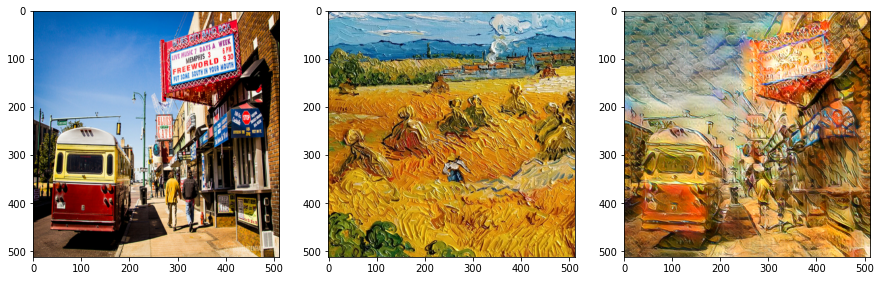

模型训练总时长为: 00:00:07


In [56]:
start_time = time.time()
for content, style in content_style_pairs:
    alpha = 1
    stylized, content_image, style_image = stylize(content, style, alpha, vgg_t7, decoder_t7, resize=[512,512])
    fig = plt.figure(figsize=(15,30))
    a=fig.add_subplot(1,3,1)
    plt.imshow(Clip_image_uint8(content_image))
    a=fig.add_subplot(1,3,2)
    plt.imshow(Clip_image_uint8(style_image))
    a=fig.add_subplot(1,3,3)
    plt.imshow(Clip_image_uint8(stylized))
    #plt.savefig('./Huang_Style_Transfer_results/results/{0}_styled.jpg'.format('Van_Gogh_starry_sky'))
    cv2.imwrite('./Huang_Style_Transfer_results/results/{0}_styled.jpg'.format('Van_Gogh_Golden_Wheat_Field'), cv2.cvtColor(stylized,cv2.COLOR_BGR2RGB))
    plt.show() 
    
    
end_time = time.time()
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))

print("模型训练总时长为: %s" % elapsed_time)

In [11]:
import cv2  
import matplotlib.pyplot as plt
img = cv2.imread('./Li_Style_Transfer_results/results/sky/res-3-result-200.jpg')
# b,g,r = cv2.split(img) 
# img_rgb = cv2.merge([r,g,b]) 
# plt.figure() 
# plt.imshow(img_rgb) 
# plt.show() 
cv2.imwrite('./1.jpg',cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

True